In [237]:
import numpy as np
import random
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt

In [238]:
def get_rnd_phi():
    # Define distributions for common regions of Ramachandran plot
    dist1 = np.random.uniform(-180, 180)  # Uniform distribution for loops
    dist2 = np.random.normal(-57, 25)  # Right-handed alpha helix
    dist3 = np.random.normal(57, 25)  # Left-handed alpha helix
    dist4 = np.random.normal(-119, 25)  # Beta sheet
    # Use random.choices to pick from the distributions
    phi = random.choices([dist1, dist2, dist3, dist4], weights=[0.7, 0.1, 0.1, 0.1], k=1)[0]
    return phi

def get_rnd_psi():
    # Define distributions for common regions of Ramachandran plot
    dist1 = np.random.uniform(-180, 180)  # Uniform distribution for loops
    dist2 = np.random.normal(-47, 25)  # Right-handed alpha helix
    dist3 = np.random.normal(47, 25)  # Left-handed alpha helix
    dist4 = np.random.normal(113, 25)  # Beta sheet
    # Use random.choices to pick from the distributions
    psi = random.choices([dist1, dist2, dist3, dist4], weights=[0.7, 0.1, 0.1, 0.1], k=1)[0]
    return psi

def get_rnd_omega():
    # For omega, most will still be trans but assign a slightly higher chance for cis
    dist1 = random.uniform(-180, 180)  # Uniform distribution
    dist2 = np.random.normal(180, 10)  # Normal distribution focused around 180
    dist3 = np.random.normal(0, 10)  # Normal distribution focused around 0
    omega = random.choices([dist1, dist2, dist3], weights=[0.05, 0.9, 0.05], k=1)[0]  
    return omega

def get_rnd_phi_psi_proline():
    phi = np.random.uniform(-120, -40)  
    psi = np.random.uniform(-60, 180)
    return phi, psi

def is_allowed_in_idps_v10(psi, phi, residue_type):
    regions = [
        {'name': 'proline', 'phi_range': (-120, -40), 'psi_range': (-60, 180), 'applicable_residues': ['P']},
        {'name': 'glycine', 'phi_range': (-180, 180), 'psi_range': (-180, 180), 'applicable_residues': ['G']},
        {'name': 'avoid_1', 'phi_range': (-8, 8), 'psi_range': (-5, 5)},
        {'name': 'avoid_2', 'phi_range': (-8, 8)},
        {'name': 'avoid_2', 'phi_range': (-185, -175)},
        {'name': 'avoid_2', 'phi_range': (175, 185)},
        {'name': 'avoid_4', 'phi_range': (166, 185), 'psi_range': (166, 185)},
    ]
    
    if residue_type == "P":
        region = regions[0]
        phi_min, phi_max = region['phi_range']
        if phi_min <= phi <= phi_max:
            psi_min, psi_max = region['psi_range']
            if psi_min <= psi <= psi_max:
                return True
            else:
                return False
        else:
            return False
    elif residue_type == "G":
        return True
    else:
        for region in regions:
            if 'avoid' in region['name']:
                phi_min, phi_max = region['phi_range']
                if phi_min <= phi <= phi_max:
                    # If there's a psi range, also check the psi value
                    if 'psi_range' in region:
                        psi_min, psi_max = region['psi_range']
                        if psi_min <= psi <= psi_max:
                            return False
                    else:
                        return False
        return True

In [239]:
def generate_psi_phi(residue_type):
    if residue_type == "P":
        phi, psi = get_rnd_phi_psi_proline()
    else:
        psi = get_rnd_psi()
        phi = get_rnd_phi()
    while not is_allowed_in_idps_v10(psi, phi, residue_type):
        psi = get_rnd_psi()
        phi = get_rnd_phi()
    return psi, phi

def parallel_psi_phi_generation(residue_type, n_steps):
    # Define how many cores to use
    num_cores = cpu_count()

    # Use multiprocessing Pool to parallelize the generation of psi and phi
    with Pool(num_cores) as pool:
        results = pool.map(generate_psi_phi, [residue_type]*n_steps)

    # Unpack results into two lists
    psi_list, phi_list = zip(*results)

    return psi_list, phi_list


In [251]:
def generate_data(residue_type, n_steps):
    psi_list, phi_list = parallel_psi_phi_generation(residue_type, n_steps)
    return psi_list, phi_list

def generate_plot(data, bins):
    psi_list, phi_list = data
    # Compute 2D histogram of psi and phi angles.
    hist, xedges, yedges = np.histogram2d(phi_list, psi_list, bins=bins, range=[[-180, 180], [-180, 180]], density=True)

    return hist

In [241]:
n_steps = 10000000
data_default = generate_data("default", n_steps)
data_G = generate_data("G", n_steps)
data_P = generate_data("P", n_steps)

In [252]:
bins = 360//8

hist_default = generate_plot(data_default, bins)
hist_G = generate_plot(data_G, bins)
hist_P = generate_plot(data_P, bins)

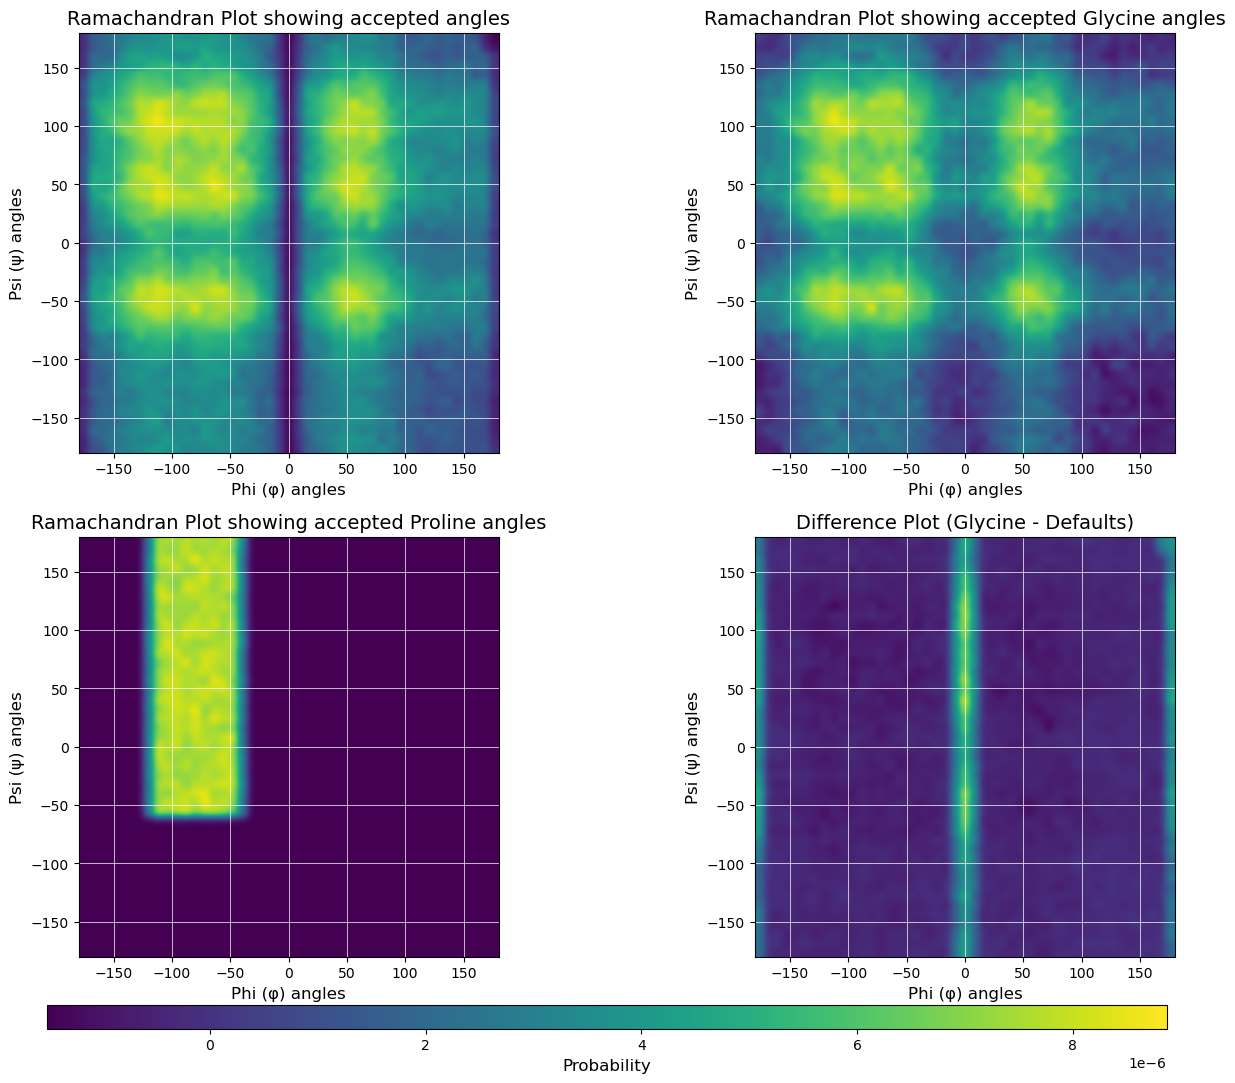

In [254]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

ax[0, 0].imshow(hist_default.T, extent=[-180, 180, -180, 180], origin='lower', cmap='viridis', interpolation='gaussian')
ax[0, 0].set_title('Ramachandran Plot showing accepted angles', fontsize=14)
ax[0, 0].grid(True, which='both', color='white', linewidth=0.5)
ax[0, 0].set_xlabel('Phi (φ) angles', fontsize=12)
ax[0, 0].set_ylabel('Psi (ψ) angles', fontsize=12)

ax[0, 1].imshow(hist_G.T, extent=[-180, 180, -180, 180], origin='lower', cmap='viridis', interpolation='gaussian')
ax[0, 1].set_title('Ramachandran Plot showing accepted Glycine angles', fontsize=14)
ax[0, 1].grid(True, which='both', color='white', linewidth=0.5)
ax[0, 1].set_xlabel('Phi (φ) angles', fontsize=12)
ax[0, 1].set_ylabel('Psi (ψ) angles', fontsize=12)

ax[1, 0].imshow(hist_P.T, extent=[-180, 180, -180, 180], origin='lower', cmap='viridis', interpolation='gaussian')
ax[1, 0].set_title('Ramachandran Plot showing accepted Proline angles', fontsize=14)
ax[1, 0].grid(True, which='both', color='white', linewidth=0.5)
ax[1, 0].set_xlabel('Phi (φ) angles', fontsize=12)
ax[1, 0].set_ylabel('Psi (ψ) angles', fontsize=12)

diff_hist = hist_G - hist_default
im = ax[1, 1].imshow(diff_hist.T, extent=[-180, 180, -180, 180], origin='lower', cmap='viridis', interpolation='gaussian')
ax[1, 1].set_title('Difference Plot (Glycine - Defaults)', fontsize=14)
ax[1, 1].grid(True, which='both', color='white', linewidth=0.5)
ax[1, 1].set_xlabel('Phi (φ) angles', fontsize=12)
ax[1, 1].set_ylabel('Psi (ψ) angles', fontsize=12)

cax = plt.axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
plt.colorbar(im, cax=cax, orientation='horizontal')
cax.set_xlabel('Probability', fontsize=12)

plt.show()
